In [ ]:
# ! pip install ftfy regex tqdm
# ! pip install git+https://github.com/openai/CLIP.git

# ! pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# # (use --upgrade --force-reinstall to upgrade)

# ! pip install scikit-image
# ! pip install matplotlib
# ! pip install opencv-python

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import save_image
import json

def vid_path(filename):
    return f'.\\data\\video\\train_all\\{filename}'

def load_video(filename):
    cap = cv2.VideoCapture(filename)
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    cap.release()
    return np.array(frames)

def load_utt(vid_no, utt_no, text_data):
    utt = text_data[vid_no]['conversation'][utt_no-1]
    vid = load_video(vid_path(utt['video_name']))
    return vid, utt

def frame_to_img(frame):
    # frame = Image.fromarray(frame).convert("RGB")
    # frame = Image.fromarray(np.array(frame)[:, :, ::-1])
    
    frame = Image.fromarray(frame[:, :, ::-1])
    return  frame

with open('data/Subtask_2_train.json') as f:
    text_data_list = json.load(f)
    # text data is a map of conversation id to conversation
    text_data = {text['conversation_ID']: text for text in text_data_list}

e:\repos_kioxia\win\mgr\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
e:\repos_kioxia\win\mgr\.venv\Lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Hey , I was doing great before I found out about you . You think it is easy for me to see you with Julie ?
anger


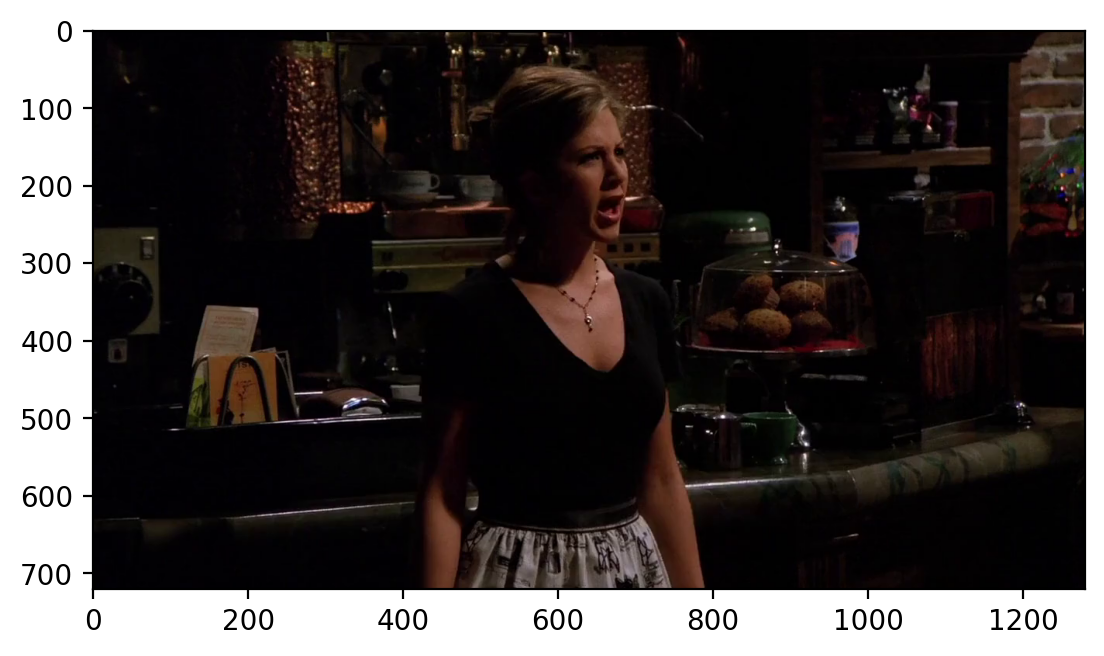

In [3]:
vid, utt = load_utt(215, 4, text_data)
print(utt['text'])
print(utt['emotion'])
img = frame_to_img(vid[0])
np.array(img).shape
plt.imshow(img)
# img = preprocess(img)

In [4]:
def get_frame_first(vid, axis=0, resize_n=224):
    frame = cv2.resize(vid[0], (resize_n,resize_n))
    return frame

def get_frame_half(vid, axis=0, resize_n=224):
    frame = cv2.resize(vid[len(vid)//2], (resize_n,resize_n))
    return frame

def get_frame_last(vid, axis=0, resize_n=224):
    frame = cv2.resize(vid[-1], (resize_n,resize_n))
    return frame

def get_comic_3(vid, axis=0, resize_n=224):
    comic_frames = [
        vid[0],  # start
        vid[len(vid)//2],
        vid[-1],  # end
    ]

    comic_frames = [cv2.resize(frame, (resize_n,resize_n)) for frame in comic_frames]

    if axis == 0:
        comic = np.zeros((resize_n*3, 224, 3), dtype=np.uint8)
        comic[:resize_n] = comic_frames[0]
        comic[resize_n:resize_n*2] = comic_frames[1]
        comic[resize_n*2:] = comic_frames[2]
    elif axis == 1:
        comic = np.zeros((resize_n, resize_n*3, 3), dtype=np.uint8)
        comic[:, :resize_n] = comic_frames[0]
        comic[:, resize_n:resize_n*2] = comic_frames[1]
        comic[:, resize_n*2:] = comic_frames[2]

    return comic

def get_comic_4(vid, resize_n=512):
    comic_frames = [
        vid[0],  # start
        vid[len(vid)//3],
        vid[len(vid)*2//3],
        vid[-1]  # end
    ]

    comic_frames = [cv2.resize(frame, (resize_n,resize_n)) for frame in comic_frames]

    comic = np.zeros((resize_n*2, resize_n*2, 3), dtype=np.uint8)
    comic[:resize_n, :resize_n] = comic_frames[0]
    comic[:resize_n, resize_n:] = comic_frames[1]
    comic[resize_n:, :resize_n] = comic_frames[2]
    comic[resize_n:, resize_n:] = comic_frames[3]

    return comic

frame_funcs = [get_frame_first, get_frame_half, get_frame_last, get_comic_3, get_comic_4]

In [7]:
vid, utt = load_utt(5, 1, text_data)

# comic = get_comic_3(vid, axis=0)
frame = get_frame_first(vid)

print(utt['text'])
frame.shape

Oh , look , wish me luck !


(224, 224, 3)

Oh , look , wish me luck !
(1024, 1024)


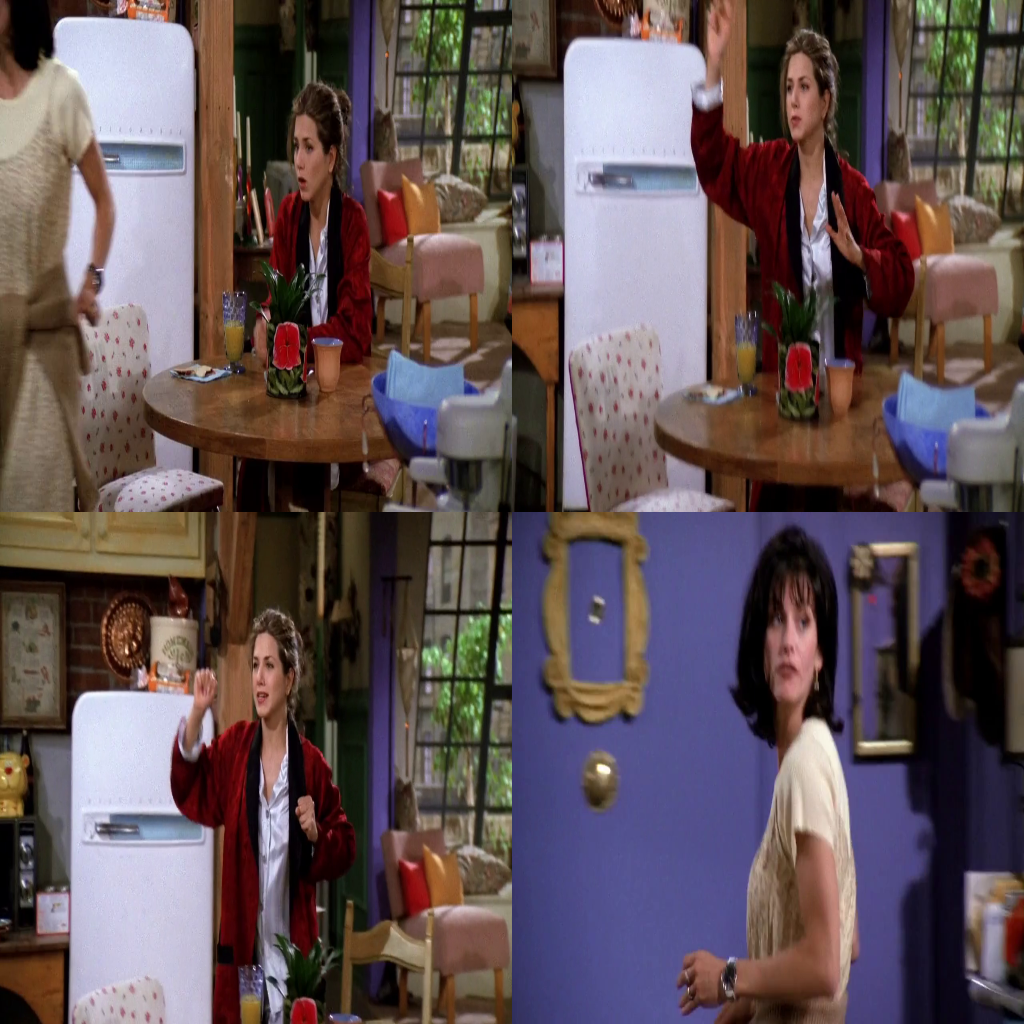

: 

In [9]:
vid, utt = load_utt(5, 1, text_data)

# comic = get_comic_3(vid, axis=0)
comic = get_comic_4(vid)
comic = frame_to_img(comic)

print(utt['text'])
# see dimensions of comic
print(comic.size)
comic

### Preprocess all images

In [9]:
len(text_data)

1374

In [194]:
# import os

# for frame_func in frame_funcs:
#     path = f'./data/preproc_test/{frame_func.__name__[4:]}'
#     os.mkdir(path)

In [191]:
vid, utt = load_utt(18, 1, text_data)
# check if vid is empty
vid.size == 0


True

In [10]:
import time

n_images = 200

start = time.time()
missed_convs = []

for c_i in list(text_data.keys()):
    conv_dict = text_data[c_i]
    if (c_i-1) % 10 == 0:
        print(f"[{round(time.time()-start, 2)}s] conv {c_i}")
    for utt_dict in conv_dict['conversation']:
        u_i = utt_dict['utterance_ID']

        vid, utt = load_utt(c_i, u_i, text_data)
        if vid.size == 0:
            missed_convs.append(c_i)
            continue

        for frame_func in frame_funcs:
            fname_jpg = utt_dict['video_name'][:-4] + '.jpg'
            path = f'./data/preproc/{frame_func.__name__[4:]}/{fname_jpg}'
                
            # print(f"Preprocessing {frame_func.__name__[4:]}/{fname_jpg}")
            try:
                comic = frame_func(vid)
                comic = frame_to_img(comic)
                # # comic = preprocess(comic) # this preproc will be done at the time of inference
                # # save_image(comic, path)
                # print(f"Saving {frame_func.__name__[4:]}/{fname_jpg}")
                comic.save(path)
            except Exception as e:
                print(f"Error: {frame_func.__name__[4:]}/{fname_jpg}")
                raise e


[0.0s] conv 1
[13.8s] conv 11
[30.85s] conv 21
[46.51s] conv 31
[63.66s] conv 41
[90.84s] conv 61
[121.55s] conv 81
[144.05s] conv 91
[189.32s] conv 121
[208.93s] conv 131
[227.3s] conv 141
[256.59s] conv 161
[269.77s] conv 171
[296.22s] conv 191
[307.27s] conv 201
[328.25s] conv 221
[336.52s] conv 231
[401.65s] conv 271
[412.7s] conv 281
[427.33s] conv 291
[437.44s] conv 301
[454.87s] conv 311
[482.61s] conv 331
[511.46s] conv 351
[528.92s] conv 361
[542.0s] conv 371
[573.75s] conv 391
[644.23s] conv 451
[678.5s] conv 471
[710.24s] conv 491
[739.26s] conv 511
[749.19s] conv 521
[776.37s] conv 541
[793.6s] conv 551
[807.05s] conv 561
[824.51s] conv 571
[838.79s] conv 581
[875.48s] conv 611
[894.19s] conv 621
[905.48s] conv 631
[921.21s] conv 641
[936.65s] conv 651
[955.78s] conv 661
[1021.04s] conv 711
[1032.95s] conv 721
[1046.84s] conv 731
[1064.24s] conv 741
[1073.71s] conv 751
[1096.43s] conv 771
[1111.54s] conv 781
[1127.79s] conv 791
[1150.39s] conv 811
[1198.39s] conv 851
[1213.

In [11]:
conv_x_utt = 0
for conv in list(text_data.items()):
    conv_x_utt += len(conv[1]['conversation'])

print("Utt count from text_data", conv_x_utt)

Utt count from text_data 13619


In [12]:
preproc_path = './data/preproc/'
preproc_folders = os.listdir(preproc_path)
print("Image counts in folders")
for folder in preproc_folders:
    print(folder, len(os.listdir(preproc_path+folder)))

Image counts in folders
.gitkeep 0
comic_3 13619
comic_4 13619
frame_first 13619
frame_half 13619
frame_last 13619


: 